# Notes for Regression:
- Year as baseline?
- Control vs. investigated variables
- Was it in the "recent news" page? or otherwise advertised?

In [182]:
import pandas as pd
import datetime
import dateutil
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import summary_table

In [194]:
df_de = pd.read_csv("events/new/events_dataframe_de.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_de['code'] = 'de'
df_en = pd.read_csv("events/new/events_dataframe_en.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_en['code'] = 'en'
df_it = pd.read_csv("events/new/events_dataframe_it.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_it['code'] = 'it'
df_es = pd.read_csv("events/new/events_dataframe_es.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_es['code'] = 'es'
df = pd.concat([df_en, df_de, df_it, df_es])
df.head(5)

,event_id,pagetitle,event_date,economic_region,continent,cat,categories,views_7_sum,views_before_mean,views_before_sum,...,views_before_min,views_before_median,views_before_increase,list_views_7_days,diff_days,year,planed,surprising,factor,code
0,Q20639899,2015 Ji'an bus accident,2015-07-01,Global South,Asia,disaster,"['Category:2015 disasters in China', 'Category...",1161,0.0,0,...,0,0.0,0,"[60, 507, 103, 148, 143, 200]",1,2015,not_planed,surprising,surprising,en
1,Q20635386,2015 Chama Cha Mapinduzi presidential primaries,2015-07-01,Global South,Africa,politics,"['Category:2015 elections in Tanzania', 'Categ...",1069,0.0,0,...,0,0.0,0,[],-1,2015,planed,not_surprising,before,en
2,Q20514322,2015 Swedish Open,2015-07-01,Global North,Europe,sports,"['Category:2015 ATP World Tour', 'Category:201...",2714,0.0,0,...,0,0.0,0,"[304, 296, 356, 356, 414, 449, 539]",-11,2015,planed,not_surprising,before,en
3,Q15699191,2015–16 UEFA Europa League,2015-07-02,Global North,Europe,sports,"['Category:2015–16 UEFA Europa League', 'Categ...",83545,10905.0,10905,...,10905,10905.0,0,"[22825, 16011, 7050, 6406, 7420, 10011, 11464]",-769,2015,planed,not_surprising,before,en
4,Q20646862,Aleppo offensive (July 2015),2015-07-02,Global South,Asia,disaster,"['Category:Aleppo in the Syrian civil war', 'C...",2372,0.0,0,...,0,0.0,0,"[777, 1595]",5,2015,not_planed,not_surprising,after,en


In [186]:
df_it_new = pd.read_csv("events/new/events_dataframe_it.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_es_new = pd.read_csv("events/new/events_dataframe_es.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})

In [197]:
print('es', len(df_es[df_es.views_7_sum > 0]), len(df_es_new[df_es_new.views_7_sum > 0]))
print('it', len(df_it[df_it.views_7_sum > 0]), len(df_it_new[df_it_new.views_7_sum > 0]))

es 3352 3352
it 2297 2297


In [7]:
# views_7_days_mean   ... mean of views wihtin 7 days after event
# list_views_7_days   ... list of views within 7 days after event
# views_7_sum         ... sum of views within 7 days after event (incl. redirects)
# views_before_mean   ... mean of views 7 days before event
# views_before_min    ... min of views 7 days before event
# ...

In [163]:
df_it

,event_id,pagetitle,event_date,economic_region,continent,cat,categories,views_7_sum,views_before_mean,views_before_sum,...,views_before_min,views_before_median,views_before_increase,list_views_7_days,diff_days,year,planed,surprising,factor,code
0,Q20514322,Swedish Open 2015,2015-07-01,Global North,Europe,sports,"['Categoria:ATP World Tour 2015', 'Categoria:S...",0,0.0,0,...,0,0.0,0,[],12,2015,not_planed,not_surprising,after,it
1,Q15699191,UEFA Europa League 2015-2016,2015-07-02,Global North,Europe,sports,"['Categoria:Calcio nel 2015', 'Categoria:Calci...",6550,883.0,883,...,883,883.0,0,"[1612, 1215, 602, 534, 620, 917, 1050]",-9,2015,planed,not_surprising,before,it
2,Q19912625,European League maschile 2015,2015-07-03,Global North,Europe,NaN,"['Categoria:European League maschile 2015', 'C...",33,0.0,0,...,0,0.0,0,[],-153,2015,planed,not_surprising,before,it
3,Q20267748,The Beast in the East,2015-07-04,Global North,Asia,NaN,['Categoria:Errori del modulo citazione - cita...,2652,0.0,0,...,0,0.0,0,[],-5,2015,planed,not_surprising,before,it
4,Q48833429,Campionati europei di corsa in montagna 2015,2015-07-04,Global North,Europe,sports,"['Categoria:Atletica leggera nel 2015', 'Categ...",0,0.0,0,...,0,0.0,0,[],730,2015,not_planed,not_surprising,after,it
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785,Q104250896,New York Film Critics Circle Awards 2020,2020-12-18,Global North,North America,culture,"['Categoria:Cinema nel 2020', 'Categoria:New Y...",94,0.0,0,...,0,0.0,0,"[13, 42, 8, 9, 10, 6, 6]",0,2020,not_planed,not_surprising,NaN,it
3786,Q102105591,"TLC: Tables, Ladders & Chairs 2020",2020-12-20,Global North,North America,NaN,"['Categoria:P345 letta da Wikidata', 'Categori...",11396,395.5,2373,...,66,447.0,499,"[1483, 6186, 1082, 462, 293, 249, 561]",-26,2020,planed,not_surprising,before,it
3787,Q96350674,Elezioni generali nella Repubblica Centrafrica...,2020-12-27,Global South,Africa,politics,['Categoria:Elezioni generali nella Repubblica...,0,0.0,0,...,0,0.0,0,[],18,2020,not_planed,not_surprising,after,it
3788,Q85736512,Elezioni generali in Niger del 2020-21,2020-12-27,Global South,Africa,politics,"['Categoria:Elezioni generali in Niger', 'Cate...",0,0.0,0,...,0,0.0,0,[],18,2020,not_planed,not_surprising,after,it


In [195]:
df_zero = df[df["views_7_sum"] == 0]
df = df[df["views_7_sum"] != 0]
df = df[df.cat != ""]
df["pagetitle"].count()

15546

In [196]:
import numpy as np
#df = df[~df.pagetitle.duplicated(keep=False)]
np.savetxt('scraping/scripts/de_articles.txt', df[df.code=='de'].pagetitle.values, fmt='%s')
np.savetxt('scraping/scripts/en_articles.txt', df[df.code=='en'].pagetitle.values, fmt='%s')
np.savetxt('scraping/scripts/it_articles.txt', df[df.code=='it'].pagetitle.values, fmt='%s')
np.savetxt('scraping/scripts/es_articles.txt', df[df.code=='es'].pagetitle.values, fmt='%s')

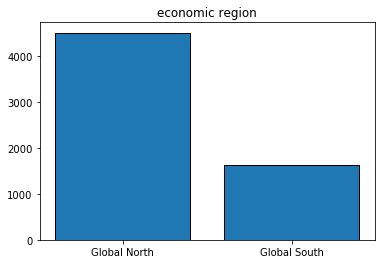

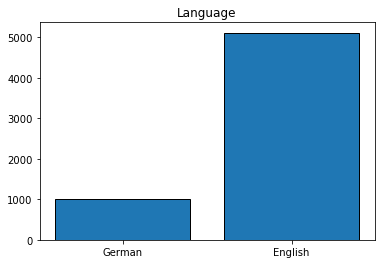

In [54]:
x = ['Global North', 'Global South']
a = len(df[(df["economic_region"]=="Global North")])
b = len(df[(df["economic_region"]=="Global South")])
y1 = np.array([a, b])

plt.figure(figsize=(6,4))
p = plt.bar(x, y1,edgecolor="k")
plt.title("economic region")
plt.show()

x = ['German', 'English']
a = len(df[(df["code"]=="de")])
b = len(df[(df["code"]=="en")])
y1 = np.array([a, b])

plt.figure(figsize=(6,4))
p = plt.bar(x, y1,edgecolor="k")
plt.title("Language")
plt.show()

In [41]:
#df = df.drop(index = [148,674,679])
df = df[~((df.factor =="before") & (df.cat == "disaster"))]
df

,pagetitle,event_date,economic_region,continent,cat,categories,views_7_sum,views_before_mean,views_before_sum,views_before_max,...,views_before_median,views_before_increase,list_views_7_days,diff_days,year,planed,surprising,factor,views_7_days_mean,code
0,2023 South Sudanese general election,2015-07-01T00:00:00Z,Global South,Africa,politics,"['Category:2023 elections in Africa', 'Categor...",166,0.000000,0,0,...,0.0,0,[],-703,2015,planed,not_surprising,before,0.000000,en
1,2015 Swedish Open,2015-07-01T00:00:00Z,Global North,Europe,sports,"['Category:2015 ATP World Tour', 'Category:201...",2714,0.000000,0,0,...,0.0,0,"[304, 296, 356, 356, 414, 449, 539]",-11,2015,planed,not_surprising,before,387.714286,en
2,2015 Ji'an bus accident,2015-07-01T00:00:00Z,Global South,Asia,disaster,"['Category:2015 disasters in China', 'Category...",1161,0.000000,0,0,...,0.0,0,"[60, 507, 103, 148, 143, 200]",1,2015,not_planed,surprising,surprising,193.500000,en
3,2015 Chama Cha Mapinduzi presidential primaries,2015-07-01T00:00:00Z,Global South,Africa,politics,"['Category:2015 elections in Tanzania', 'Categ...",1069,0.000000,0,0,...,0.0,0,[],-1,2015,planed,not_surprising,before,0.000000,en
4,Aleppo offensive (July 2015),2015-07-02T00:00:00Z,Global South,Asia,disaster,"['Category:Aleppo in the Syrian civil war', 'C...",2372,0.000000,0,0,...,0.0,0,"[777, 1595]",5,2015,not_planed,not_surprising,after,1186.000000,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,Handball-Europameisterschaft der Frauen 2020,2020-12-20,Global North,Europe,sports,['Kategorie:Handball-Europameisterschaft der F...,19163,320.000000,2240,548,...,321.0,387,"[2015, 4036, 1924, 2032, 3308, 3611, 2237]",-885,2020,planed,not_surprising,before,2737.571429,de
1681,Bombenanschlag in Nashville 2020,2020-12-25,Global North,North America,disaster,"['Kategorie:Geschichte (Nashville)', 'Kategori...",505,0.000000,0,0,...,0.0,0,"[316, 189]",5,2020,not_planed,not_surprising,after,252.500000,de
1683,Parlamentswahl in Niger 2020,2020-12-27,Global South,Africa,politics,"['Kategorie:Parlamentswahl 2020', 'Kategorie:W...",290,0.000000,0,0,...,0.0,0,"[20, 32, 10, 27, 13, 19, 19]",0,2020,not_planed,not_surprising,NaN,20.000000,de
1684,World Team Challenge 2020,2020-12-28,Global North,Europe,sports,"['Kategorie:Biathlonveranstaltung 2020', 'Kate...",727,59.666667,179,70,...,55.0,15,"[381, 229, 42, 23, 15, 23, 14]",-3,2020,planed,not_surprising,before,103.857143,de


In [148]:
d = {'views_before_sum': df['views_before_sum'].apply(lambda x:np.log(x+1)),
     'views_before_mean': df['views_before_mean'].apply(lambda x:np.log(x+1)),
     'views_before_median': df['views_before_median'].apply(lambda x:np.log(x+1)),
     'views_before_max': df['views_before_max'].apply(lambda x:np.log(x+1)),
     'views_before_min': df['views_before_min'].apply(lambda x:np.log(x+1)),
     'views_before_increase': df['views_before_increase'].apply(lambda x:np.log(x+abs(min(df.views_before_increase))+1)),
     'views_7_sum': df['views_7_sum'].apply(lambda x:np.log(x+1)),
     'diff_days':df['diff_days'].apply(lambda x:np.log(x+abs(min(df.diff_days))+1)),
     'economic_region':df['economic_region'],
     'cat': df['cat'],
     'planed':df['planed'],
     'surprising': df['surprising'],
     'factor':df['factor'],
     'code': df['code']
    }
data = pd.DataFrame(data=d)
data['bing_attention'] = data.bing_news.apply(lambda views: 'low' if views < 6 else 'high')

AttributeError: 'DataFrame' object has no attribute 'bing_news'

In [34]:
data

,views_before_sum,views_before_mean,views_before_median,views_before_max,views_before_min,views_before_increase,views_7_sum,diff_days,economic_region,cat,planed,surprising,factor,code
3,9.524056,8.137980,8.186325,8.302266,7.812783,10.439103,10.529560,8.666647,Global North,politics,planed,not_surprising,before,de
4,5.537334,4.848116,4.848116,5.068904,4.564348,10.469710,7.052721,8.646817,Global North,sports,planed,not_surprising,before,de
10,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,9.411075,8.668196,Global North,disaster,not_planed,not_surprising,NaN,de
19,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,9.783295,8.668196,Global North,disaster,not_planed,not_surprising,NaN,de
22,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,6.230481,8.668368,Global North,disaster,not_planed,surprising,surprising,de
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6320,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,11.340427,8.668196,Global South,disaster,not_planed,not_surprising,NaN,en
6321,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,9.991361,8.668540,Global North,disaster,not_planed,not_surprising,after,en
6322,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,10.553962,8.668712,Global North,disaster,not_planed,not_surprising,after,en
6323,10.148471,8.202796,7.860956,9.373309,7.054450,10.731624,12.328609,7.986505,Global North,sports,planed,not_surprising,before,en


In [59]:
data[pd.isna(data.cat)]

,views_before_sum,views_before_mean,views_before_median,views_before_max,views_before_min,views_before_increase,views_7_sum,diff_days,economic_region,cat,planed,surprising,factor,code
59,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,4.060443,8.668196,Global South,NaN,not_planed,not_surprising,NaN,en
80,4.532599,2.649210,2.079442,3.713572,1.098612,10.468318,6.040255,8.666992,Global North,NaN,planed,not_surprising,before,en
146,9.583833,7.638336,7.360104,8.508152,6.835185,10.571650,11.286326,8.660601,Global North,NaN,planed,not_surprising,before,en
175,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,10.071457,8.668540,Global South,NaN,not_planed,not_surprising,after,en
182,5.337538,3.420066,3.332205,3.951244,2.944439,10.467664,5.590987,8.467583,Global South,NaN,planed,not_surprising,before,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5903,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,10.033989,8.668540,Global North,NaN,not_planed,not_surprising,after,en
5957,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,7.710205,8.668196,Global North,NaN,not_planed,not_surprising,NaN,en
6263,7.726213,5.782946,5.497168,6.786717,4.890349,10.489105,8.644883,8.602820,Global South,NaN,planed,not_surprising,before,en
6265,0.000000,0.000000,0.000000,0.000000,0.000000,10.467920,9.270400,8.668196,Global South,NaN,not_planed,not_surprising,NaN,en


In [99]:
data.corr()

,views_before_sum,views_before_mean,views_before_median,views_before_max,views_before_min,views_before_increase,views_7_sum,diff_days
views_before_sum,1.000000,0.993732,0.989263,0.995709,0.974712,0.250089,0.381897,-0.136720
views_before_mean,0.993732,1.000000,0.997188,0.996953,0.988009,0.272200,0.421997,-0.138599
views_before_median,0.989263,0.997188,1.000000,0.990032,0.991881,0.273055,0.424329,-0.139790
views_before_max,0.995709,0.996953,0.990032,1.000000,0.976394,0.264861,0.404866,-0.135890
views_before_min,0.974712,0.988009,0.991881,0.976394,1.000000,0.279163,0.449383,-0.144030
views_before_increase,0.250089,0.272200,0.273055,0.264861,0.279163,1.000000,0.236389,-0.108276
views_7_sum,0.381897,0.421997,0.424329,0.404866,0.449383,0.236389,1.000000,-0.138621
diff_days,-0.136720,-0.138599,-0.139790,-0.135890,-0.144030,-0.108276,-0.138621,1.000000


In [101]:
model = smf.ols(formula='views_7_sum ~ (economic_region + cat) * code', data=data.dropna()).fit()    
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            views_7_sum   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     33.91
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           1.27e-58
Time:                        13:33:49   Log-Likelihood:                -11353.
No. Observations:                5198   AIC:                         2.273e+04
Df Residuals:                    5188   BIC:                         2.279e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      8.4752      0.212     39.949      0.000       8.059       8.891
economic_region[T.Global South]               -0.9401      0.181     -5.180      0.000      -1.296      -0.584
cat[T.disaster]                                0.0134      0.309      0.043      0.965      -0.592       0.619
cat[T.politics]                                0.5070      0.248      2.041      0.041       0.020       0.994
cat[T.sports]                                 -1.5896      0.246     -6.474      0.000      -2.071      -1.108
code[T.en]                                     0.0312      0.235      0.133      0.894      -0.429       0.491
economic_region[T.Global South]:code[T.en]     0.9049      0.197      4.592      0.000       0.519       1.291
cat[T.disaster]:code[T.en]                    -0.0504      0.346     -0.146      0.884      -0.729       0.628
cat[T.politics]:code[T.en]                    -0.2667      0.272     -0.980      0.327      -0.800       0.267
cat[T.sports]:code[T.en]                       1.9038      0.269      7.065      0.000       1.376       2.432
==============================================================================
Omnibus:                        0.013   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.994   Jarque-Bera (JB):                0.026
Skew:                          -0.001   Prob(JB):                        0.987
Kurtosis:                       2.989   Cond. No.                         35.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
model = smf.ols(formula='views_7_sum ~ views_before_min * cat * code',data=data.dropna()).fit()    
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            views_7_sum   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     363.4
Date:                Mon, 20 Dec 2021   Prob (F-statistic):               0.00
Time:                        13:59:02   Log-Likelihood:                -9817.4
No. Observations:                5198   AIC:                         1.966e+04
Df Residuals:                    5184   BIC:                         1.975e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       5.2815      0.363     14.543      0.000       4.570       5.993
cat[T.disaster]                                 2.8216      0.397      7.109      0.000       2.043       3.600
cat[T.politics]                                 0.8878      0.400      2.222      0.026       0.105       1.671
cat[T.sports]                                  -0.4258      0.390     -1.092      0.275      -1.190       0.338
code[T.en]                                      0.1681      0.389      0.432      0.666      -0.594       0.930
cat[T.disaster]:code[T.en]                      0.1795      0.430      0.418      0.676      -0.663       1.022
cat[T.politics]:code[T.en]                      1.9308      0.426      4.536      0.000       1.096       2.765
cat[T.sports]:code[T.en]                        0.5223      0.420      1.242      0.214      -0.302       1.347
views_before_min                                0.8113      0.084      9.625      0.000       0.646       0.977
views_before_min:cat[T.disaster]              8.41e-16   4.84e-16      1.738      0.082   -1.08e-16    1.79e-15
views_before_min:cat[T.politics]               -0.1698      0.091     -1.859      0.063      -0.349       0.009
views_before_min:cat[T.sports]                 -0.1154      0.094     -1.230      0.219      -0.299       0.068
views_before_min:code[T.en]                    -0.0819      0.089     -0.922      0.357      -0.256       0.092
views_before_min:cat[T.disaster]:code[T.en] -1.394e-16   2.73e-17     -5.112      0.000   -1.93e-16   -8.59e-17
views_before_min:cat[T.politics]:code[T.en]    -0.3409      0.097     -3.533      0.000      -0.530      -0.152
views_before_min:cat[T.sports]:code[T.en]       0.0826      0.099      0.835      0.404      -0.111       0.276
==============================================================================
Omnibus:                      188.993   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              485.873
Skew:                           0.153   Prob(JB):                    3.12e-106
Kurtosis:                       4.466   Cond. No.                     6.13e+22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.28e-41. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""